# Jupyter Notebook - Projet Banklytics
## Estimation de la Valeur des Biens Immobiliers

Version mise à jour inspirée des meilleures pratiques de preprocessing et d'optimisation.

Ce notebook suit la méthodologie du projet, de l'analyse à la soumission, en intégrant un pipeline Scikit-Learn robuste et une optimisation d'hyperparamètres avec Optuna.

Configuration de l'environnement et des différents imports

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb
import optuna

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

Fonctions utilisées

In [51]:
# Display missing values
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

## 1. Phase d'Idéation : Compréhension du Contexte et des Données

In [52]:
# 1.1 Chargement des données
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print(f"Données d'entraînement chargées : {train_df.shape}")
    print(f"Données de test chargées : {test_df.shape}")
except FileNotFoundError:
    print("Erreur : Assurez-vous que les fichiers 'train.csv' et 'test.csv' sont présents.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

if not train_df.empty:
    train_ID = train_df['Id']
    test_ID = test_df['Id']
    train_df.drop('Id', axis=1, inplace=True)
    test_df.drop('Id', axis=1, inplace=True)

Données d'entraînement chargées : (1460, 81)
Données de test chargées : (1459, 80)


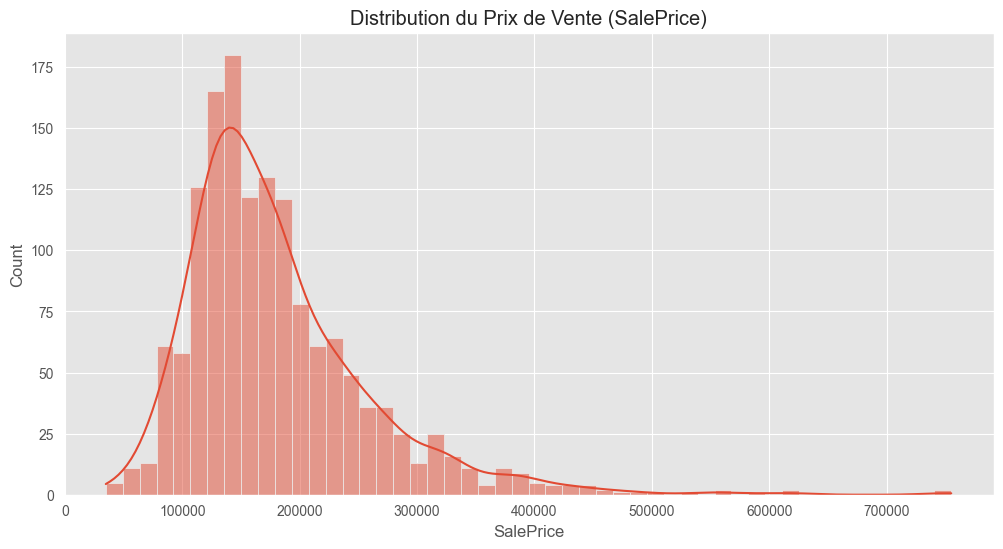

Asymétrie (Skewness) du prix de vente : 1.88
La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.


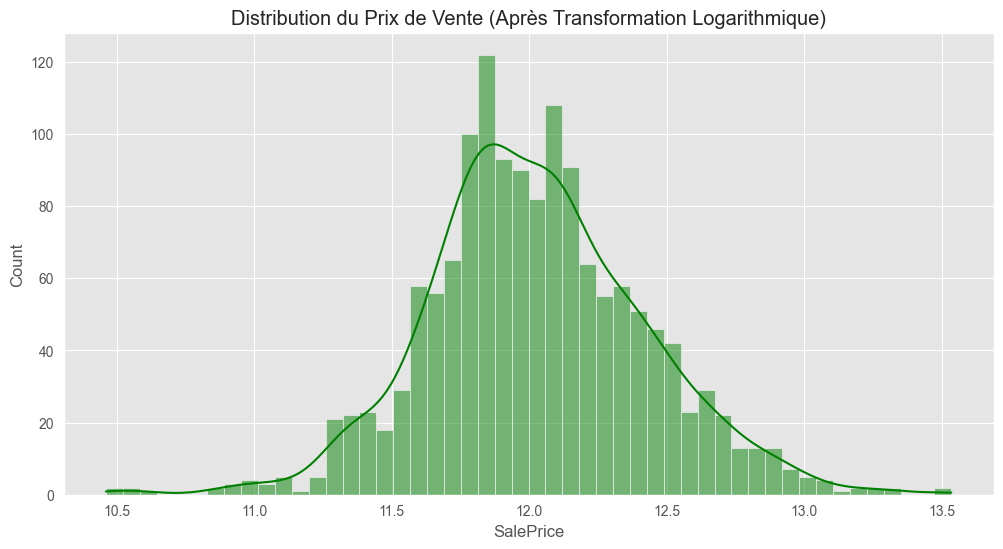

Asymétrie après transformation : 0.12


In [53]:
# 1.2 Analyse Exploratoire des Données (EDA)
if 'SalePrice' in train_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df['SalePrice'], kde=True, bins=50)
    plt.title('Distribution du Prix de Vente (SalePrice)')
    plt.show()
    print(f"Asymétrie (Skewness) du prix de vente : {train_df['SalePrice'].skew():.2f}")
    print("La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.")

    target = np.log1p(train_df["SalePrice"])

    plt.figure(figsize=(12, 6))
    sns.histplot(target, kde=True, bins=50, color='green')
    plt.title('Distribution du Prix de Vente (Après Transformation Logarithmique)')
    plt.show()
    print(f"Asymétrie après transformation : {target.skew():.2f}")

Il convient maintenant de nous intéresser de plus près aux données que nous avons à disposition afin de créer nos modèles. Nous allons dans un premier temps les diviser en trois catégories :
- Les données qualitatives
- Les données quantitatives
- Les dates



In [54]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

Une fois la catégorisation effectuée, nous avons controlé la qualité du dataset sur lequel nous allons entrainer nos modèles et certaines données sont manquantes ou alors non utilisables en l'état. Nous devons alors les nettoyer et les rendre utilisables par nos modèles. Afin de garder une cohérence, nous allons concaténer les données d'entrainements ainsi que les données de test pour être sur de traiter les données de la même manière.

Faisons dans un premier temps l'état des lieux des différentes valeurs que l'on pourrait qualifier de manquantes.

In [55]:
data_df = pd.concat([train_df, test_df])

Nombre de données quantitatives manquantes


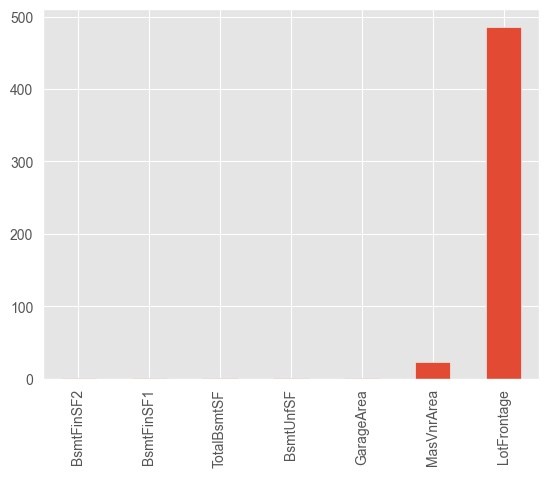

In [56]:
print(f"Nombre de données quantitatives manquantes")
plot_missing(data_df[quantitative])

Nombre de données qualitatives manquantes


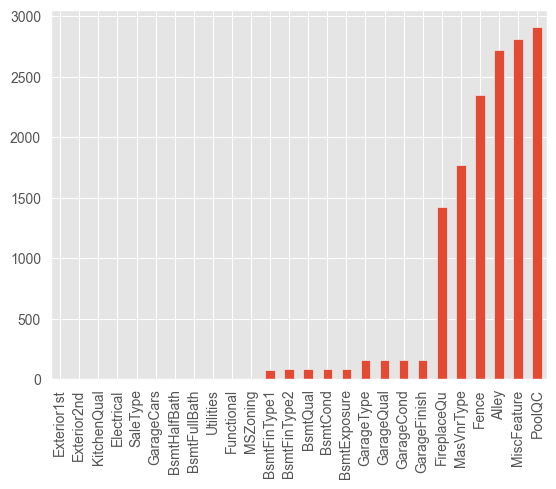

In [57]:
print(f"Nombre de données qualitatives manquantes")
plot_missing(data_df[qualitative])

Nombre de données dates manquantes


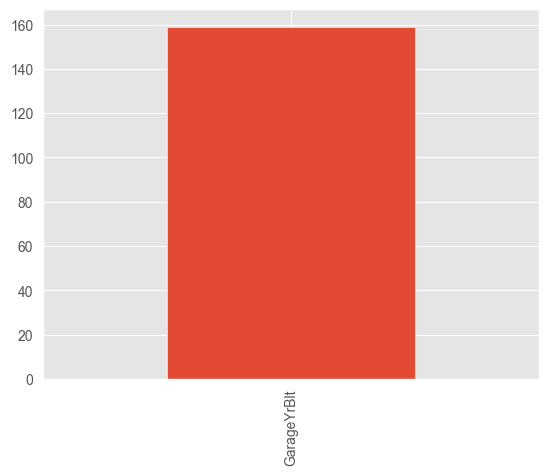

In [58]:
print(f"Nombre de données dates manquantes")
plot_missing(data_df[date])

Nous ne pouvons pas laisser ces données comme ça car elles seront inexploitable par le modèle. Par conséquent, en fonction du type de données nous allons devoir interpreter ce cela veut signifer. Par exemple, en ce qui concerne la donnée LotFrontage, NA signifie qu'il n'y a pas de rue collée à la propriété. Comme LotFrontage est une valeur quantitative, nous pouvons alors remplacé ce NA par 0 ce qui permettra au modèle de comprendre la donnée sans pour autant perdre l'information qu'elle représente.  
  
Certaines valeurs qualitatives comme GarageType ont également des données manquantes notées NA dans notre dataset cependant nous devons les traiter différemment puisqu'il s'agit de données qualitative. Nous avons décider de laisser NA pour toutes les données qualitatives et nous savons que cette notation n'indique pas l'absence de données (null) mais bien une information qui a été recensée.  
  
Concernant les colonnes de types date, seul GarageYrBlt contient des valeurs NA. Afin d'unifier cette donnée, nous avons décidé de remplacer par le valeur -1 qui consisteraient à indiquer l'absence de garage.

In [59]:
# Function to fill missing data with a constant value
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

Etant donné l'écart des années de ventes dans notre dataset, il nous faut convertir les différentes colonnes de dates (`YearBuilt`, `YearRemodAdd`, et `GarageYrBlt`) en durée afin d'unifier les durées entre l'année de vente et les différentes dates.

In [60]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [61]:
def clean(data) :
    data_clean = data.copy()
    
    # Traitement des valeurs manquantes
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_constant(data_clean, columns = date, constant = -1)

    # Transformation des dates
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [74]:
train_clean_df = clean(train_df)

## Modèle Baseline et choix des variables pour ce dernier  

Afin de pouvoir créer un modèle Baseline simple, nous devons séléctionner les variables qui vont être le plus correlées avec le logarithme du prix de vente.  
  
Pour se faire, nous devons encoder les variables qualitatives en variable numériques afin de calculer leur corrélation. Une solution à ce problème serait de remplacer la variable par la moyenne de la variable cible associée. Ceci entrainera donc une correlation entre la variable qualitative et la nouvelle variable créée.

In [75]:
# Encodage des variables qualitatives par la moyenne de la cible (mean encoding)
def mean_encode(df, qualitative_cols, target_col_name):
    df_encoded = df.copy()
    for col in qualitative_cols:
        means = df_encoded.groupby(col)[target_col_name].mean()
        df_encoded[col + '_mean_encoded'] = df_encoded[col].map(means)
    return df_encoded

# Application sur le train_df avec target (log(SalePrice)) comme liste ou série
if 'SalePrice' in train_clean_df.columns:
    train_clean_df['target'] = target  # Ajoute la colonne temporaire
    train_encoded = mean_encode(train_clean_df, qualitative, 'target')
    print(train_encoded[[col for col in train_encoded.columns if col.endswith('_mean_encoded')]].head())
    train_encoded.drop('target', axis=1, inplace=True)  # Nettoie après

   MSSubClass_mean_encoded  MSZoning_mean_encoded  Street_mean_encoded  \
0                12.339979              12.085891            12.025529   
1                12.052794              12.085891            12.025529   
2                12.339979              12.085891            12.025529   
3                11.964052              12.085891            12.025529   
4                12.339979              12.085891            12.025529   

   Alley_mean_encoded  LotShape_mean_encoded  LandContour_mean_encoded  \
0           12.037682              11.936101                   12.0227   
1           12.037682              11.936101                   12.0227   
2           12.037682              12.163471                   12.0227   
3           12.037682              12.163471                   12.0227   
4           12.037682              12.163471                   12.0227   

   Utilities_mean_encoded  LotConfig_mean_encoded  LandSlope_mean_encoded  \
0               12.024189        

Corrélation de Pearson avec log(SalePrice) :
target                       1.000000
SalePrice                    0.948374
OverallQual                  0.817185
Neighborhood_mean_encoded    0.755518
GrLivArea                    0.700927
                               ...   
KitchenAbvGr                -0.147548
EnclosedPorch               -0.149050
GarageYrBlt                 -0.349096
YearRemodAdd                -0.568136
YearBuilt                   -0.587290
Name: target, Length: 92, dtype: float64


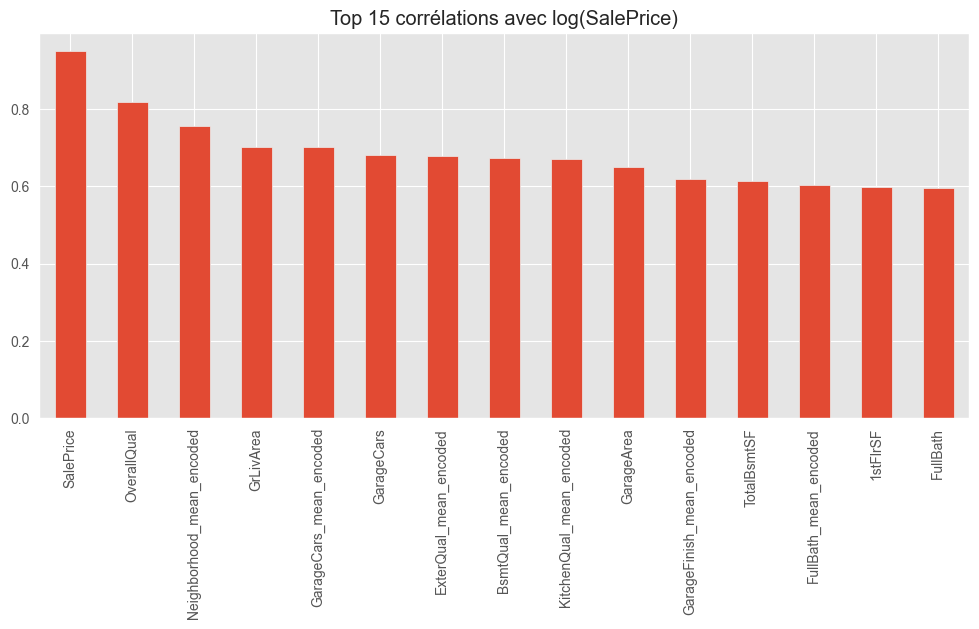

In [78]:
# Ajoute la colonne log(SalePrice) si besoin
if 'SalePrice' in train_encoded.columns:
    train_encoded['target'] = np.log1p(train_encoded['SalePrice'])

    # Calcule la corrélation de Pearson avec log(SalePrice)
    correlations = train_encoded.corr(numeric_only=True)['target'].sort_values(ascending=False)
    print("Corrélation de Pearson avec log(SalePrice) :")
    print(correlations)

    # Affiche les 15 variables les plus corrélées (hors LogSalePrice lui-même)
    correlations.drop('target').head(15).plot.bar(figsize=(12,5), title="Top 15 corrélations avec log(SalePrice)")
    plt.show()

## 2. Phase de Design : Ingénierie des Données et Pipeline de Modélisation

In [63]:
# Séparation des features (X) et de la cible (y)
if 'SalePrice' in train_df.columns:
    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']
    X_test = test_df.copy()

# Ingénierie des Features
all_data = pd.concat([X, X_test], axis=0)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.5].index
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat], lam)

X = all_data.iloc[:len(y)]
X_test = all_data.iloc[len(y):]

In [64]:
# Pipelines de prétraitement
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

## 3. Phase de Validation : Optimisation des Hyperparamètres avec Optuna

In [65]:
print("\n--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(full_pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print(f"\nMeilleur score RMSLE (validation croisée): {study.best_value:.5f}")
print("Meilleurs hyperparamètres trouvés:")
print(study.best_params)

optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

[I 2025-06-23 17:46:35,222] A new study created in memory with name: no-name-0b0462c9-0acb-419f-8dc0-4ce8f6521f32



--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---


[I 2025-06-23 17:46:40,115] Trial 0 finished with value: 28000.287109375 and parameters: {'n_estimators': 2103, 'learning_rate': 0.023079163535230127, 'max_depth': 3, 'subsample': 0.9127236019732095, 'colsample_bytree': 0.7577233059868768, 'reg_alpha': 4.519523891341008e-07, 'reg_lambda': 2.4140643260781196e-06}. Best is trial 0 with value: 28000.287109375.
[I 2025-06-23 17:46:49,292] Trial 1 finished with value: 28315.659765625 and parameters: {'n_estimators': 2074, 'learning_rate': 0.04844725199824798, 'max_depth': 6, 'subsample': 0.6303166956783677, 'colsample_bytree': 0.662514534751919, 'reg_alpha': 0.03149996246726166, 'reg_lambda': 6.899600230792605e-06}. Best is trial 0 with value: 28000.287109375.
[I 2025-06-23 17:46:49,292] Trial 1 finished with value: 28315.659765625 and parameters: {'n_estimators': 2074, 'learning_rate': 0.04844725199824798, 'max_depth': 6, 'subsample': 0.6303166956783677, 'colsample_bytree': 0.662514534751919, 'reg_alpha': 0.03149996246726166, 'reg_lambda':


Meilleur score RMSLE (validation croisée): 26887.68633
Meilleurs hyperparamètres trouvés:
{'n_estimators': 1542, 'learning_rate': 0.016543749101433185, 'max_depth': 4, 'subsample': 0.5899028354580902, 'colsample_bytree': 0.5054440349428526, 'reg_alpha': 9.289394388826741e-05, 'reg_lambda': 1.4018953471776385e-08}


## 4. Phase de Déploiement : Entraînement final et Prédiction

In [66]:
print("\n--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---")

final_model = xgb.XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])
final_pipeline.fit(X, y)
print("Entraînement terminé.")

log_predictions = final_pipeline.predict(X_test)
final_predictions = np.expm1(log_predictions)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_predictions})
submission.to_csv('submission_optimized.csv', index=False)

print("\nFichier 'submission_optimized.csv' généré avec succès.")
print("Aperçu des prédictions :")
print(submission.head())


--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---
Entraînement terminé.

Fichier 'submission_optimized.csv' généré avec succès.
Aperçu des prédictions :
     Id  SalePrice
0  1461        inf
1  1462        inf
2  1463        inf
3  1464        inf
4  1465        inf
Entraînement terminé.

Fichier 'submission_optimized.csv' généré avec succès.
Aperçu des prédictions :
     Id  SalePrice
0  1461        inf
1  1462        inf
2  1463        inf
3  1464        inf
4  1465        inf


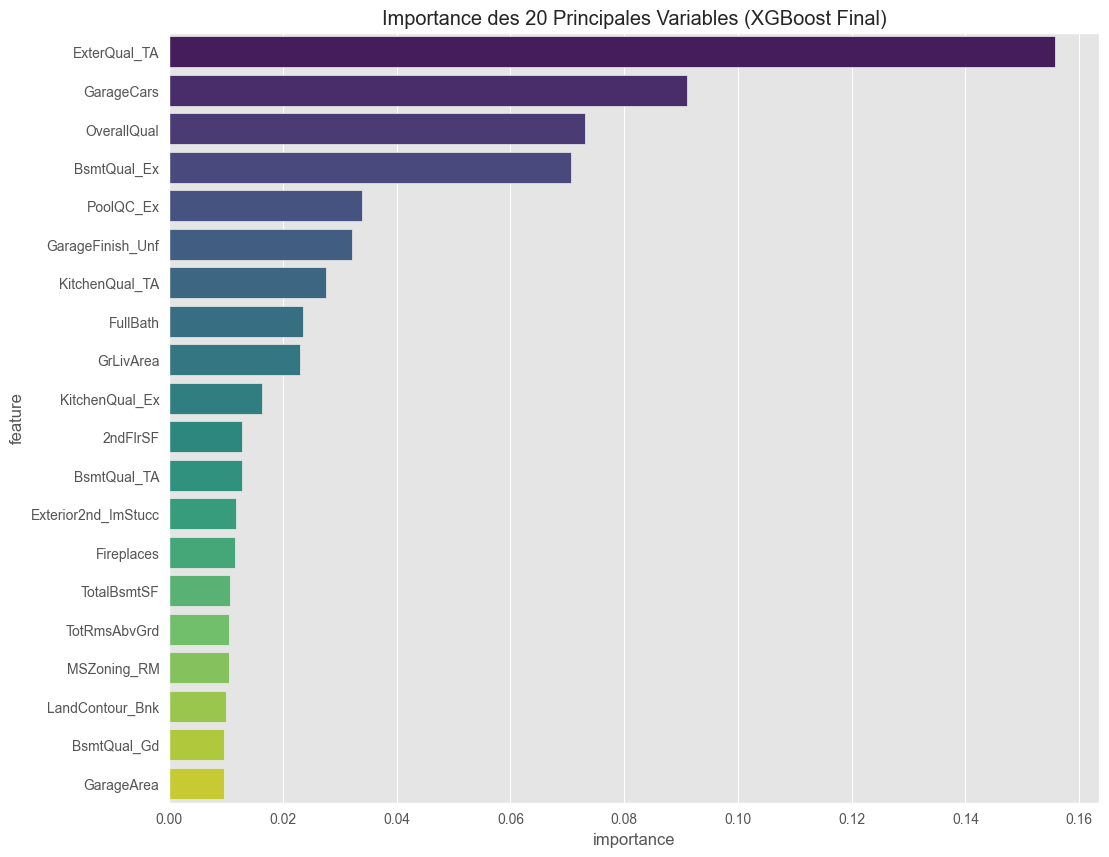

In [67]:
# 4.3 Analyse de l'Importance des Variables
ohe_feature_names = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Importance des 20 Principales Variables (XGBoost Final)')
plt.show()

## Conclusion

Ce notebook a appliqué une démarche robuste et moderne :

1. Utilisation d'un pipeline Scikit-Learn pour un prétraitement propre et reproductible.
2. Optimisation automatisée des hyperparamètres avec Optuna pour maximiser la performance.
3. Entraînement d'un modèle final performant et génération des prédictions.
4. Analyse de l'importance des variables pour une meilleure explicabilité du modèle.

Le modèle est prêt à être intégré comme outil d'aide à la décision pour les analystes de Banklytics.